### Import Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yapwh1208/cats-breed-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cats-breed-dataset


### Import Library

In [2]:
 !pip install imbalanced-learn

In [3]:
import os
import numpy as np
import cv2
from skimage import io
from skimage.color import rgb2gray
import random
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
from imblearn.ensemble import BalancedRandomForestClassifier

np.random.seed(42)

IMAGE_SIZE = (128, 128)

### EDA

Total breeds available: 5


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


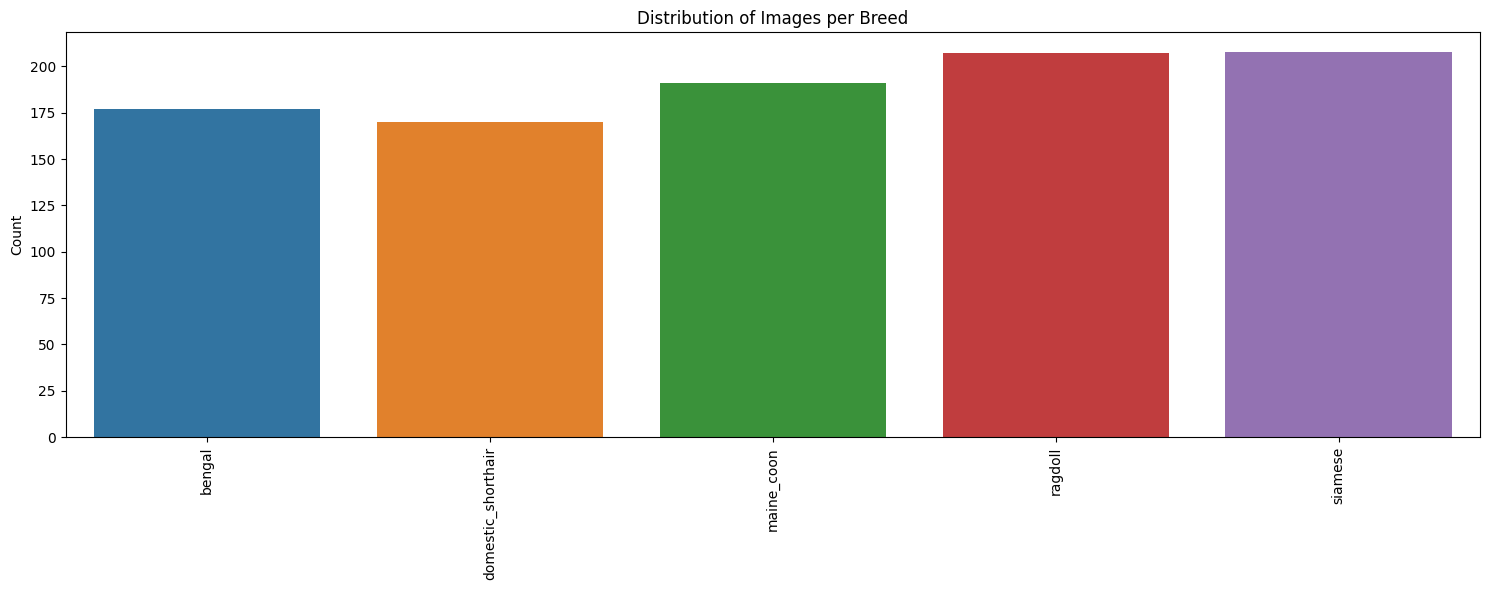


Selected 5 breeds with sufficient samples:
['bengal', 'domestic_shorthair', 'maine_coon', 'ragdoll', 'siamese']


In [4]:
dataset_path = os.path.join(path, "cat_v1")

def load_and_analyze_dataset(path):
    breeds = sorted(os.listdir(path))
    breed_counts = {}
    print(f"Total breeds available: {len(breeds)}")
    for breed in breeds:
        breed_path = os.path.join(path, breed)
        count = len(os.listdir(breed_path))
        breed_counts[breed] = count
    plt.figure(figsize=(15, 6))
    sns.barplot(x=list(breed_counts.keys()), y=list(breed_counts.values()))
    plt.xticks(rotation=90)
    plt.title('Distribution of Images per Breed')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    return breed_counts

breed_counts = load_and_analyze_dataset(dataset_path)
selected_breeds = [breed for breed, count in breed_counts.items() if count >= 120][:8]
print(f"\nSelected {len(selected_breeds)} breeds with sufficient samples:")
print(selected_breeds)

### Preprocessing

In [5]:
# Function to apply Gaussian and Median filters (Noise Reduction)
def apply_filters(image_path):
    # Load image
    image = io.imread(image_path)
    image_gray = rgb2gray(image)  # Convert to grayscale for better results

    # Apply Gaussian filter
    gaussian_filtered = cv2.GaussianBlur(image_gray, (5, 5), 0)

    # Apply Median filter
    median_filtered = cv2.medianBlur((image_gray * 255).astype(np.uint8), 5)

    return image_gray, gaussian_filtered, median_filtered

# Function for Contrast Stretching
def contrast_stretching(image):
    # Define the min and max pixel values for contrast stretching
    min_val = np.min(image)
    max_val = np.max(image)

    # Apply contrast stretching
    stretched_image = (image - min_val) * (255 / (max_val - min_val))
    return np.uint8(stretched_image)

# Function to apply Histogram Equalization and Contrast Stretching
def apply_image_enhancements(image_path):
    # Load image
    image = io.imread(image_path)
    image_gray = rgb2gray(image)  # Convert to grayscale for better results

    # Apply Histogram Equalization
    hist_eq_image = cv2.equalizeHist((image_gray * 255).astype(np.uint8))

    # Apply Contrast Stretching
    contrast_stretched_image = contrast_stretching(image_gray * 255)

    return image_gray, hist_eq_image, contrast_stretched_image

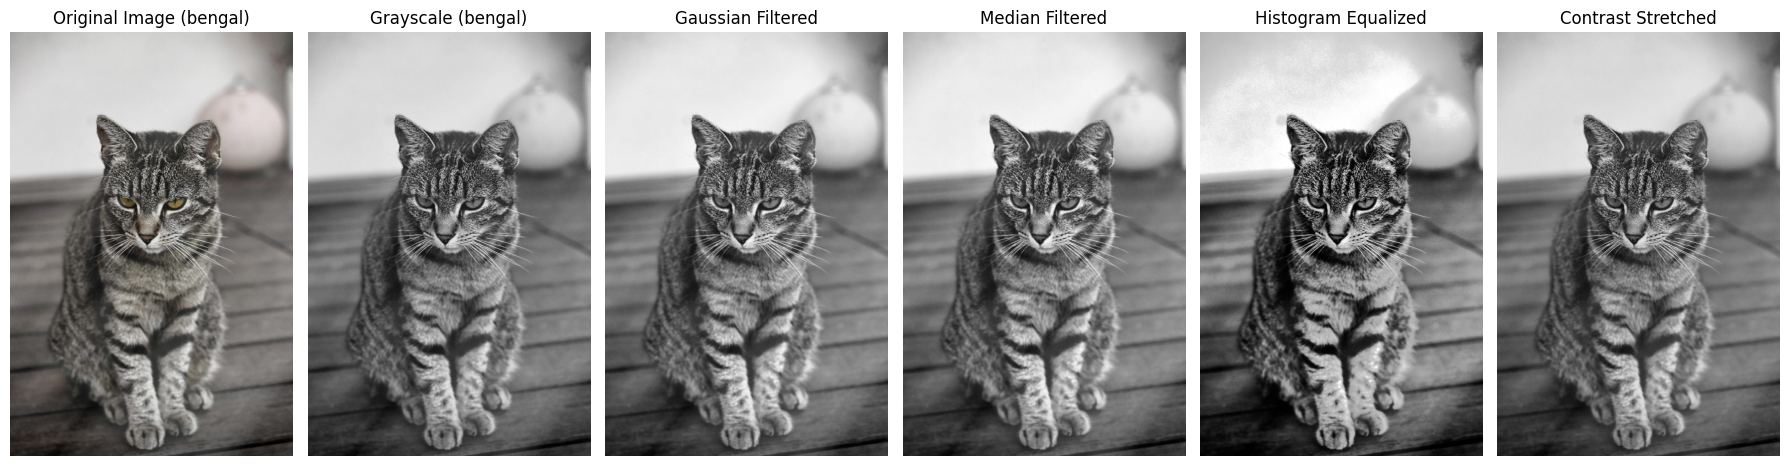

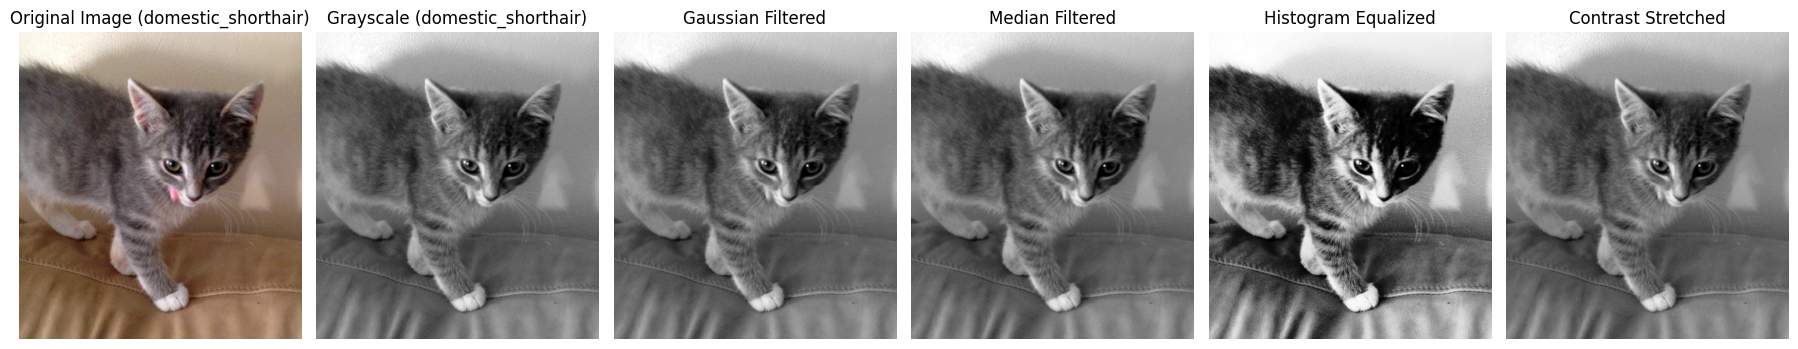

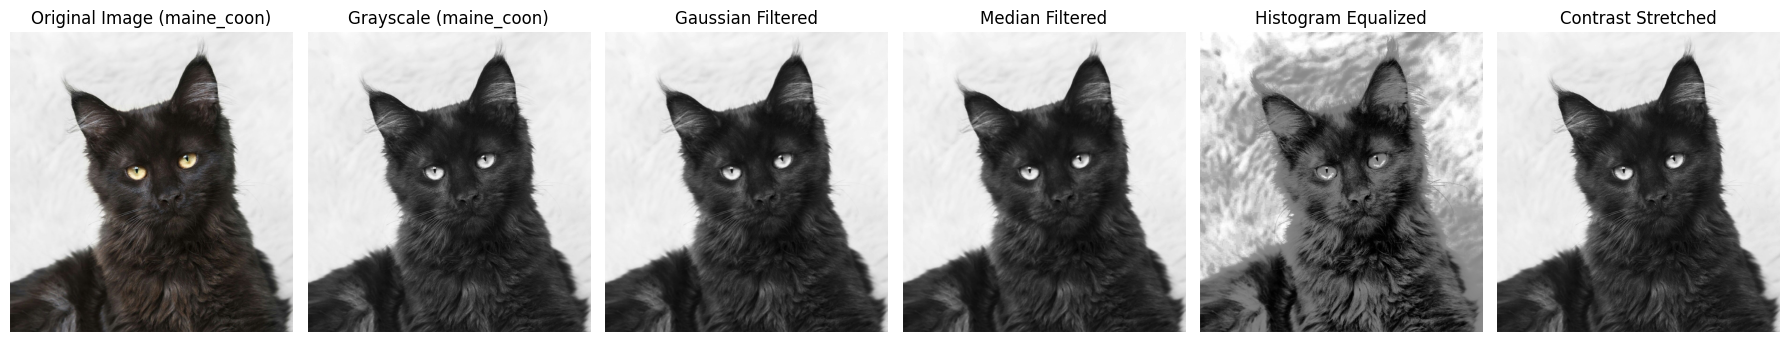

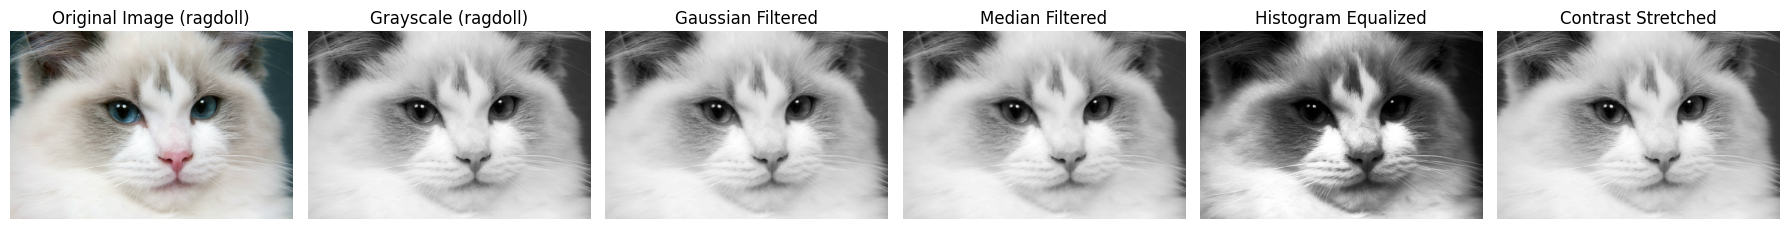

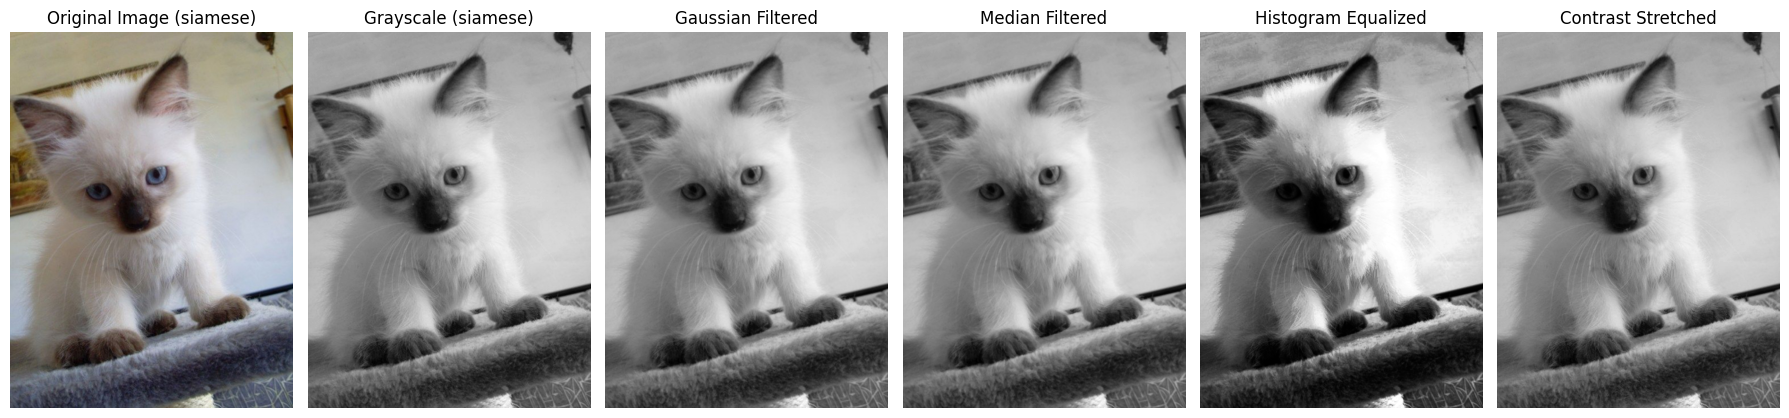

In [6]:
# Loop through each breed and show an image with both Noise Reduction and Image Enhancements applied
for breed in selected_breeds:
    breed_images = os.listdir(os.path.join(dataset_path, breed))

    # Select the first image from the breed
    image_path = os.path.join(dataset_path, breed, breed_images[0])
    img_rgb = cv2.imread(image_path)
    if img_rgb is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Apply Noise Reduction
    original, gaussian_filtered, median_filtered = apply_filters(image_path)

    # Apply Image Enhancements
    original_image, hist_eq_image, contrast_stretched_image = apply_image_enhancements(image_path)  # Unpack three values

    # Plotting the images for both Noise Reduction and Image Enhancement in a single row
    fig, axes = plt.subplots(1, 6, figsize=(18, 6))  # 1 row, 5 columns

    # Plot each image in the same row
    axes[0].imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Original Image ({breed})")
    axes[0].axis('off')

    axes[1].imshow(original, cmap='gray')
    axes[1].set_title(f"Grayscale ({breed})")
    axes[1].axis('off')

    axes[2].imshow(gaussian_filtered, cmap='gray')
    axes[2].set_title("Gaussian Filtered")
    axes[2].axis('off')

    axes[3].imshow(median_filtered, cmap='gray')
    axes[3].set_title("Median Filtered")
    axes[3].axis('off')

    axes[4].imshow(hist_eq_image, cmap='gray')
    axes[4].set_title("Histogram Equalized")
    axes[4].axis('off')

    axes[5].imshow(contrast_stretched_image, cmap='gray')
    axes[5].set_title("Contrast Stretched")
    axes[5].axis('off')

    plt.tight_layout()
    plt.show()

### Feature Extraction

In [7]:
def extract_enhanced_features(img_array):
    img = cv2.resize(img_array, (256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_features = hog(gray, orientations=12, pixels_per_cell=(32, 32),
                       cells_per_block=(3, 3), feature_vector=True)
    lbp = local_binary_pattern(gray, 24, 3, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=256, range=(0, 256))
    lbp_hist = lbp_hist / (lbp_hist.sum() + 1e-6)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    color_features = []
    for i in range(3):
        channel = lab[:, :, i]
        color_features.extend([
            np.mean(channel),
            np.std(channel),
            np.median(channel),
            np.min(channel),
            np.max(channel)
        ])
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    texture_features = [
        np.mean(sobelx),
        np.std(sobelx),
        np.mean(sobely),
        np.std(sobely)
    ]
    return np.concatenate([hog_features, lbp_hist, color_features, texture_features])

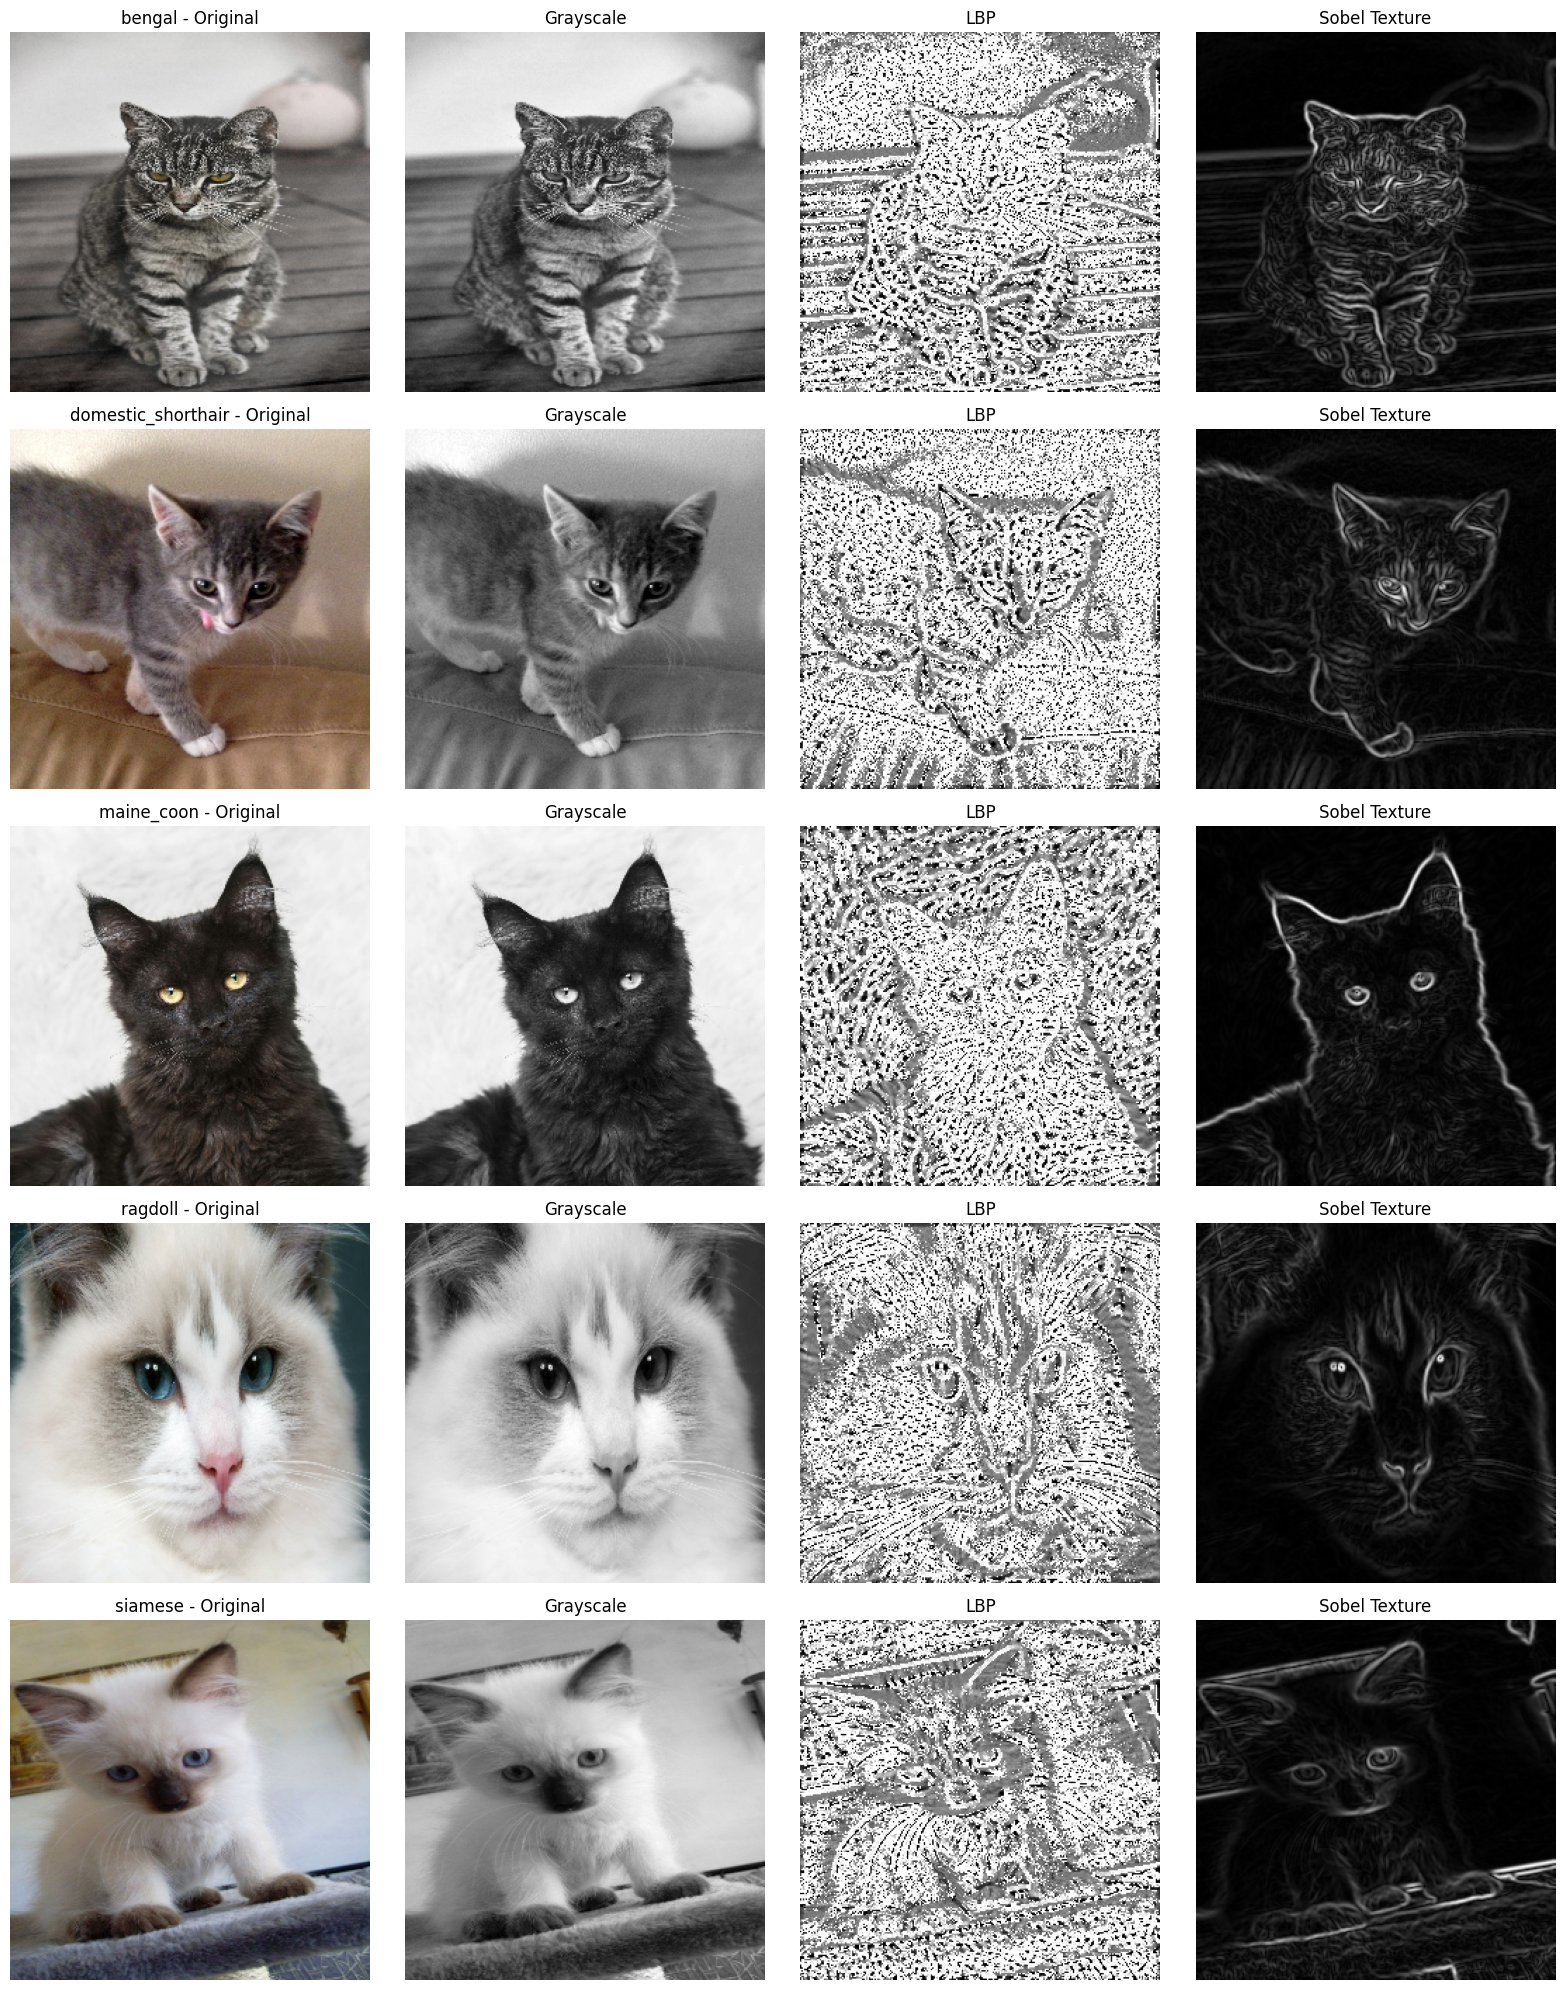

In [8]:
def visualize_feature_extract_all_breeds(breeds, dataset_path):
    num_breeds = len(breeds)
    fig, axs = plt.subplots(num_breeds, 4, figsize=(16, 4 * num_breeds))

    for i, breed in enumerate(breeds):
        # Ambil gambar pertama
        breed_path = os.path.join(dataset_path, breed)
        img_name = os.listdir(breed_path)[0]
        img_path = os.path.join(breed_path, img_name)

        # Baca
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(img, (256, 256))
        gray = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
        lbp = local_binary_pattern(gray, 24, 3, method='uniform')
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
        sobel_combined = np.hypot(sobelx, sobely)

        # Plot
        axs[i, 0].imshow(resized)
        axs[i, 0].set_title(f"{breed} - Original")
        axs[i, 1].imshow(gray, cmap='gray')
        axs[i, 1].set_title("Grayscale")
        axs[i, 2].imshow(lbp, cmap='gray')
        axs[i, 2].set_title("LBP")
        axs[i, 3].imshow(sobel_combined, cmap='gray')
        axs[i, 3].set_title("Sobel Texture")

        for j in range(4):
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Panggil fungsi
visualize_feature_extract_all_breeds(selected_breeds, dataset_path)

### Data Augmentation

In [9]:
def manual_augmentation(img):
    augmented = [cv2.flip(img, 1)]
    rows, cols = img.shape[:2]
    for angle in [10, -10, 15, -15]:
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        augmented.append(cv2.warpAffine(img, M, (cols, rows)))
    for beta in [30, -30]:
        augmented.append(cv2.convertScaleAbs(img, beta=beta))
    return augmented

In [10]:
X, y = [], []
target_samples = 250

print("\nExtracting features with augmentation...")
for breed in tqdm(selected_breeds):
    breed_path = os.path.join(dataset_path, breed)
    images = os.listdir(breed_path)[:target_samples]
    for img_name in images:
        img_path = os.path.join(breed_path, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            features = extract_enhanced_features(img)
            X.append(features)
            y.append(breed)
            if len(images) < target_samples:
                augmented_imgs = manual_augmentation(img)
                for aug_img in augmented_imgs[:min(3, target_samples - len(images))]:
                    features = extract_enhanced_features(aug_img)
                    X.append(features)
                    y.append(breed)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

X = np.array(X)
y = np.array(y)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nFinal dataset shape:", X.shape)
print("Class distribution:", Counter(y))


Extracting features with augmentation...


100%|██████████| 5/5 [04:23<00:00, 52.79s/it]


Final dataset shape: (3812, 4163)
Class distribution: Counter({'siamese': 832, 'ragdoll': 828, 'maine_coon': 764, 'bengal': 708, 'domestic_shorthair': 680})


In [11]:
X = np.array(X)
y = np.array(y)

In [12]:
print("Fitur extraction done:", X.shape, y.shape)

Fitur extraction done: (3812, 4163) (3812,)


### Scalling fitur

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectFromModel(
    BalancedRandomForestClassifier(n_estimators=100, random_state=42),
    threshold='median'
)
X_selected = selector.fit_transform(X_scaled, y_encoded)

X_final = X_selected

print(f"\nReduced feature dimensions: {X_final.shape[1]}")


Reduced feature dimensions: 2082


### Data Splitting

In [14]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_final, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

### Model Building

In [15]:
rf = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
svm = SVC(probability=True, random_state=42)
knn = KNeighborsClassifier(n_jobs=-1)

#### Model Parameter

In [91]:
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [10, 20, 30, 40, 50, 60],
    'min_samples_split': [2, 3, 5, 10, 15],
    'max_features': ['sqrt', 'log2'], 
    'min_samples_leaf': [1, 2, 4, 7],
    'bootstrap': [True, False]
}


svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 15, 100, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': [3, 4, 5]  # For polynomial kernel
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'cosine'],
    'p': [1, 2]  # Manhattan (p=1), Euclidean (p=2)
}

### HyperParameter Tuning

In [52]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rf_random_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42, verbose=3)
svm_random_search = RandomizedSearchCV(svm, svm_param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42, verbose=3)
knn_random_search = RandomizedSearchCV(knn, knn_param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42, verbose=3)

In [93]:
rf_random_search.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=0.597 total time=  11.6s
[CV 2/5] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=0.585 total time=  11.6s
[CV 4/5] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=0.603 total time=  11.6s
[CV 1/5] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=0.600 total time=  11.7s
[CV 5/5] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=0.611 total time=  11.3s
[CV 1/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=7, min_samples_split=2, n_estimators=500;, score=0.575 total time=  46.5s
[CV 3/5] END boo

RandomizedSearchCV(cv=5,
                   estimator=BalancedRandomForestClassifier(n_jobs=-1,
                                                            random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4, 7],
                                        'min_samples_split': [2, 3, 5, 10, 15],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600]},
                   random_state=42, verbose=3)

In [54]:
svm_random_search.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5] END C=15, degree=3, gamma=scale, kernel=linear;, score=0.510 total time=  58.6s
[CV 2/5] END C=15, degree=3, gamma=scale, kernel=linear;, score=0.510 total time=  59.3s
[CV 3/5] END C=15, degree=3, gamma=scale, kernel=linear;, score=0.526 total time=  59.7s
[CV 1/5] END C=15, degree=3, gamma=scale, kernel=linear;, score=0.539 total time= 1.0min
[CV 1/5] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.539 total time=  56.7s
[CV 2/5] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.510 total time=  59.5s
[CV 5/5] END C=15, degree=3, gamma=scale, kernel=linear;, score=0.530 total time= 1.0min
[CV 3/5] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.526 total time= 1.0min
[CV 4/5] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.510 total time=  58.1s
[CV 5/5] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.530 total time= 1.1min
[CV 1/5] END C=1000, degree=4, gamma=scale, 

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 15, 100, 1000],
                                        'degree': [3, 4, 5],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['rbf', 'linear', 'poly']},
                   random_state=42, verbose=3)

In [55]:
knn_random_search.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END metric=manhattan, n_neighbors=13, p=2, weights=distance;, score=0.526 total time=   4.5s
[CV 4/5] END metric=manhattan, n_neighbors=13, p=2, weights=distance;, score=0.597 total time=   4.5s
[CV 2/5] END metric=manhattan, n_neighbors=13, p=2, weights=distance;, score=0.544 total time=   4.5s
[CV 3/5] END metric=manhattan, n_neighbors=13, p=2, weights=distance;, score=0.584 total time=   4.5s
[CV 1/5] END metric=manhattan, n_neighbors=7, p=1, weights=uniform;, score=0.503 total time=   4.6s
[CV 5/5] END metric=manhattan, n_neighbors=13, p=2, weights=distance;, score=0.599 total time=   4.7s
[CV 2/5] END metric=manhattan, n_neighbors=7, p=1, weights=uniform;, score=0.503 total time=   4.7s
[CV 3/5] END metric=manhattan, n_neighbors=7, p=1, weights=uniform;, score=0.584 total time=   4.7s
[CV 1/5] END metric=euclidean, n_neighbors=11, p=2, weights=distance;, score=0.479 total time=   0.4s
[CV 2/5] END metric=euclide

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'chebyshev', 'cosine'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 13, 15,
                                                        17],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, verbose=3)

In [94]:
best_rf = rf_random_search.best_estimator_

In [56]:
best_rf = rf_random_search.best_estimator_
best_svm = svm_random_search.best_estimator_
best_knn = knn_random_search.best_estimator_

### Random Forest after & before tuning

In [95]:
before_rf = BalancedRandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42, n_jobs=-1)
before_rf.fit(X_train_full, y_train_full)

BalancedRandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [96]:
after_rf = best_rf
after_rf.fit(X_train_full, y_train_full)

BalancedRandomForestClassifier(max_depth=40, min_samples_split=3,
                               n_estimators=400, n_jobs=-1, random_state=42)

In [97]:
before_rf_pred = before_rf.predict(X_test)
after_rf_pred = after_rf.predict(X_test)

In [98]:
before_rf_acc = accuracy_score(y_test, before_rf_pred)
after_rf_acc = accuracy_score(y_test, after_rf_pred)

In [99]:
before_rf_labels = le.inverse_transform(y_test)
after_rf_labels = le.inverse_transform(y_test)

In [100]:
before_rf_pred_labels = le.inverse_transform(before_rf_pred)
after_rf_pred_labels = le.inverse_transform(after_rf_pred)

In [101]:
print(f"\nTest Accuracy (Random Forest Before Tuning): {before_rf_acc:.2%}")
print("Classification Report:")
print(classification_report(before_rf_labels, before_rf_pred_labels))


Test Accuracy (Random Forest Before Tuning): 60.55%
Classification Report:
                    precision    recall  f1-score   support

            bengal       0.67      0.75      0.71       142
domestic_shorthair       0.58      0.41      0.48       136
        maine_coon       0.63      0.65      0.64       153
           ragdoll       0.58      0.67      0.63       166
           siamese       0.56      0.53      0.54       166

          accuracy                           0.61       763
         macro avg       0.60      0.60      0.60       763
      weighted avg       0.60      0.61      0.60       763



In [102]:
print(f"\nTest Accuracy (Random Forest After Tuning): {after_rf_acc:.2%}")
print("Classification Report:")
print(classification_report(after_rf_labels, after_rf_pred_labels))


Test Accuracy (Random Forest After Tuning): 69.20%
Classification Report:
                    precision    recall  f1-score   support

            bengal       0.75      0.77      0.76       142
domestic_shorthair       0.65      0.50      0.56       136
        maine_coon       0.73      0.73      0.73       153
           ragdoll       0.68      0.76      0.72       166
           siamese       0.65      0.68      0.67       166

          accuracy                           0.69       763
         macro avg       0.69      0.69      0.69       763
      weighted avg       0.69      0.69      0.69       763



### SVM after & before tuning

In [65]:
before_svm = SVC(C=0.1, gamma='scale', kernel='rbf', probability=True, random_state=42)
before_svm.fit(X_train_full, y_train_full)

SVC(C=0.1, probability=True, random_state=42)

In [66]:
after_svm = best_svm
after_svm.fit(X_train_full, y_train_full)

SVC(C=15, gamma='auto', kernel='poly', probability=True, random_state=42)

In [67]:
before_svm_pred = before_svm.predict(X_test)
after_svm_pred = after_svm.predict(X_test)

In [68]:
before_svm_acc = accuracy_score(y_test, before_svm_pred)
after_svm_acc = accuracy_score(y_test, after_svm_pred)

In [69]:
before_svm_labels = le.inverse_transform(y_test)
after_svm_labels = le.inverse_transform(y_test)

In [70]:
before_svm_pred_labels = le.inverse_transform(before_svm_pred)
after_svm_pred_labels = le.inverse_transform(after_svm_pred)

In [71]:
print(f"\nTest Accuracy (SVM Before Tuning): {before_svm_acc:.2%}")
print("Classification Report:")
print(classification_report(before_svm_labels, before_svm_pred_labels))


Test Accuracy (SVM Before Tuning): 46.40%
Classification Report:
                    precision    recall  f1-score   support

            bengal       0.62      0.52      0.57       142
domestic_shorthair       0.00      0.00      0.00       136
        maine_coon       0.59      0.50      0.54       153
           ragdoll       0.47      0.53      0.50       166
           siamese       0.35      0.70      0.47       166

          accuracy                           0.46       763
         macro avg       0.41      0.45      0.42       763
      weighted avg       0.41      0.46      0.42       763



In [72]:
print(f"\nTest Accuracy (SVM After Tuning): {after_svm_acc:.2%}")
print("Classification Report:")
print(classification_report(after_svm_labels, after_svm_pred_labels))


Test Accuracy (SVM After Tuning): 79.03%
Classification Report:
                    precision    recall  f1-score   support

            bengal       0.80      0.85      0.83       142
domestic_shorthair       0.81      0.74      0.77       136
        maine_coon       0.77      0.85      0.81       153
           ragdoll       0.84      0.73      0.78       166
           siamese       0.74      0.78      0.76       166

          accuracy                           0.79       763
         macro avg       0.79      0.79      0.79       763
      weighted avg       0.79      0.79      0.79       763



### KNN after & before tuning

In [73]:
before_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean', n_jobs=-1)
before_knn.fit(X_train_full, y_train_full)

KNeighborsClassifier(metric='euclidean', n_jobs=-1)

In [74]:
after_knn = best_knn
after_knn.fit(X_train_full, y_train_full)

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=3)

In [75]:
before_knn_pred = before_knn.predict(X_test)
after_knn_pred = after_knn.predict(X_test)

In [76]:
before_knn_acc = accuracy_score(y_test, before_knn_pred)
after_knn_acc = accuracy_score(y_test, after_knn_pred)

In [77]:
before_knn_labels = le.inverse_transform(y_test)
after_knn_labels = le.inverse_transform(y_test)

In [78]:
before_knn_pred_labels = le.inverse_transform(before_knn_pred)
after_knn_pred_labels = le.inverse_transform(after_knn_pred)

In [79]:
print(f"\nTest Accuracy (K-Neighbor Nearest Before Tuning): {before_knn_acc:.2%}")
print("Classification Report:")
print(classification_report(before_knn_labels, before_knn_pred_labels))


Test Accuracy (K-Neighbor Nearest Before Tuning): 54.39%
Classification Report:
                    precision    recall  f1-score   support

            bengal       0.42      0.80      0.55       142
domestic_shorthair       0.43      0.57      0.49       136
        maine_coon       0.64      0.60      0.62       153
           ragdoll       0.81      0.44      0.57       166
           siamese       0.72      0.36      0.48       166

          accuracy                           0.54       763
         macro avg       0.61      0.55      0.54       763
      weighted avg       0.62      0.54      0.54       763



In [80]:
print(f"\nTest Accuracy (K-Neighbor Nearest After Tuning): {after_knn_acc:.2%}")
print("Classification Report:")
print(classification_report(after_knn_labels, after_knn_pred_labels))


Test Accuracy (K-Neighbor Nearest After Tuning): 71.17%
Classification Report:
                    precision    recall  f1-score   support

            bengal       0.67      0.87      0.76       142
domestic_shorthair       0.62      0.66      0.64       136
        maine_coon       0.77      0.74      0.75       153
           ragdoll       0.74      0.67      0.70       166
           siamese       0.77      0.63      0.70       166

          accuracy                           0.71       763
         macro avg       0.71      0.71      0.71       763
      weighted avg       0.72      0.71      0.71       763



### Ensemble Learning with best parameter

In [114]:
ensemble = VotingClassifier(
    estimators=[('rf', best_rf), ('svm', best_svm), ('knn', best_knn)],
    voting='soft', n_jobs=-1, verbose=3
)

In [115]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

print("\nCross-validating...")
for train_idx, val_idx in tqdm(skf.split(X_train_full, y_train_full), total=5):
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]
    ensemble.fit(X_train, y_train)
    val_pred = ensemble.predict(X_val)
    cv_scores.append(accuracy_score(y_val, val_pred))

print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.2%} ± {np.std(cv_scores):.2%}")


Cross-validating...


  0%|          | 0/5 [00:00<?, ?it/s]

[Voting] ...................... (3 of 3) Processing knn, total=   0.0s
[Voting] ....................... (1 of 3) Processing rf, total=  21.5s
[Voting] ...................... (2 of 3) Processing svm, total=  45.9s


 20%|██        | 1/5 [00:48<03:12, 48.02s/it]

[Voting] ...................... (3 of 3) Processing knn, total=   0.0s
[Voting] ....................... (1 of 3) Processing rf, total=  20.7s
[Voting] ...................... (2 of 3) Processing svm, total=  46.1s


 40%|████      | 2/5 [01:36<02:24, 48.07s/it]

[Voting] ...................... (3 of 3) Processing knn, total=   0.0s
[Voting] ....................... (1 of 3) Processing rf, total=  21.7s
[Voting] ...................... (2 of 3) Processing svm, total=  46.2s


 60%|██████    | 3/5 [02:24<01:36, 48.18s/it]

[Voting] ...................... (3 of 3) Processing knn, total=   0.0s
[Voting] ....................... (1 of 3) Processing rf, total=  20.9s
[Voting] ...................... (2 of 3) Processing svm, total=  45.2s


 80%|████████  | 4/5 [03:11<00:47, 47.82s/it]

[Voting] ...................... (3 of 3) Processing knn, total=   0.0s
[Voting] ....................... (1 of 3) Processing rf, total=  21.8s
[Voting] ...................... (2 of 3) Processing svm, total=  45.8s


100%|██████████| 5/5 [03:59<00:00, 47.90s/it]


Cross-validation scores: [0.7737704918032787, 0.7852459016393443, 0.7737704918032787, 0.7754098360655738, 0.7816091954022989]
Mean CV accuracy: 77.80% ± 0.46%


In [116]:
print("\nTraining final model...")
ensemble.fit(X_train_full, y_train_full)

y_test_pred = ensemble.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

y_test_pred_labels = le.inverse_transform(y_test_pred)
y_test_labels = le.inverse_transform(y_test)

print(f"\nTest Accuracy (Ensemble Learning): {test_acc:.2%}")
print("Classification Report:")
print(classification_report(y_test_labels, y_test_pred_labels))


Training final model...
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s
[Voting] ....................... (1 of 3) Processing rf, total=  27.3s
[Voting] ...................... (2 of 3) Processing svm, total= 1.2min

Test Accuracy (Ensemble Learning): 81.52%
Classification Report:
                    precision    recall  f1-score   support

            bengal       0.86      0.87      0.86       142
domestic_shorthair       0.85      0.71      0.77       136
        maine_coon       0.84      0.84      0.84       153
           ragdoll       0.78      0.83      0.80       166
           siamese       0.77      0.83      0.80       166

          accuracy                           0.82       763
         macro avg       0.82      0.81      0.81       763
      weighted avg       0.82      0.82      0.81       763



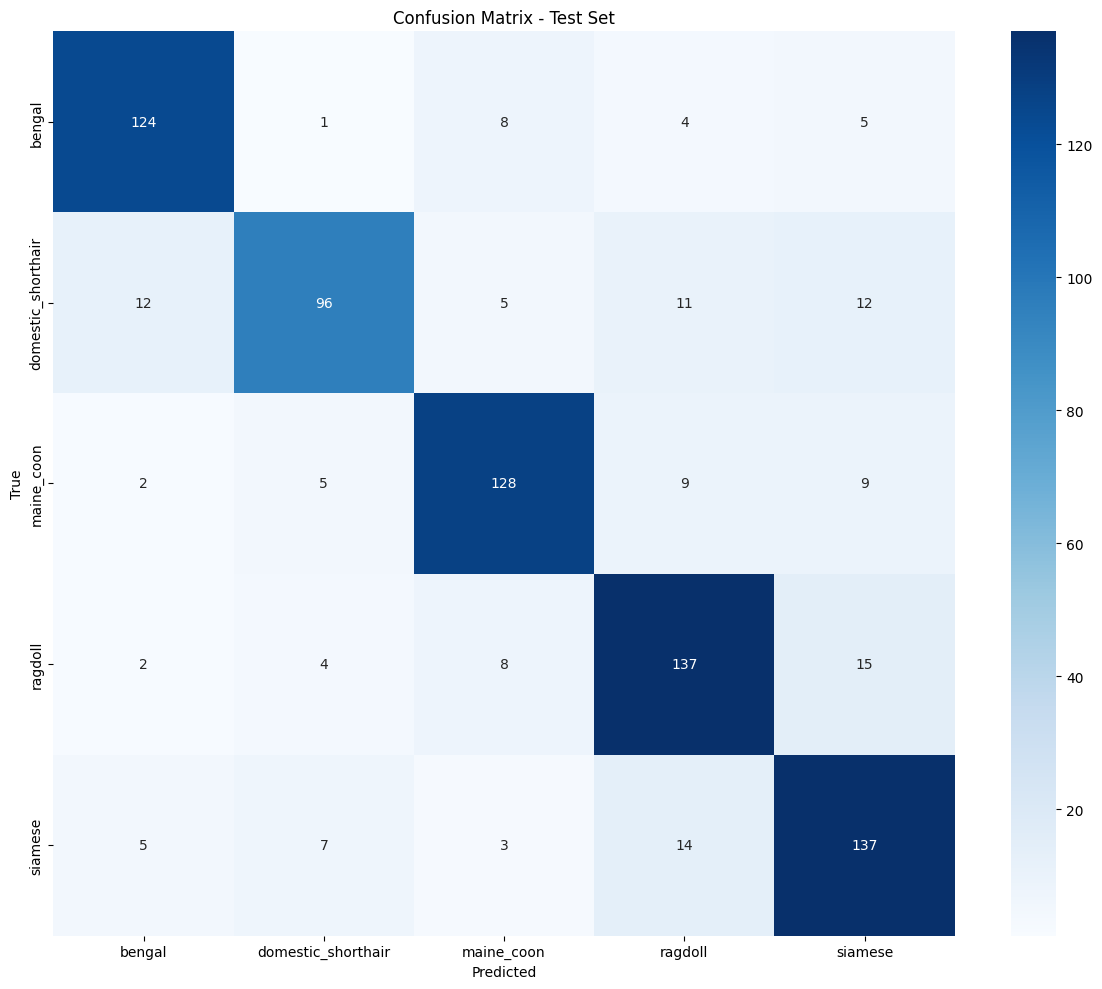

In [117]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [118]:
joblib.dump({
    'model': ensemble,
    'scaler': scaler,
    'selector': selector,
    'label_encoder': le,
    'classes': selected_breeds
}, 'cat_breed_classifier_v2.pkl')

print("\nModel saved successfully!")


Model saved successfully!
